In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

#### unzip data files

In [2]:
from zipfile import ZipFile

zf = ZipFile('KingHaraldsCovidQuest.zip')
zf.extractall()
zf.close()

In [22]:
%%time
import datatable as dt
import pandas as pd
import os

folder_name = 'KingHaraldsCovidQuest'
df_dict = {}
for csv_name in os.listdir(folder_name):
    df_holder = dt.fread(f'{folder_name}\{csv_name}').to_pandas()
    df_dict[csv_name] = df_holder

Wall time: 70 ms


#### Generate EDA html files with pandas_profiling

In [15]:
from pandas_profiling import ProfileReport
import shutil

generate_pd_prof, output_in_cell = False, False
pd_prof_dir = 'pd_prof_html'
if generate_pd_prof:
    if os.path.exists(pd_prof_dir):
        shutil.rmtree(pd_prof_dir)
    os.mkdir(pd_prof_dir)
    for df_name in list(df_dict.keys()):
        pd_prof = ProfileReport(df_dict[df_name])
        if output_in_cell:
            pd_prof.to_notebook.iframe()
        else:
            df_name_no_csv = df_name.replace('.csv','')
            pd_prof.to_file(output_file=f'{pd_prof_dir}\{df_name_no_csv}.html')

#### I have chosen to work with the ReportedCovidCasesByDay.csv as a time series problem

In [27]:
import platform
import pystan

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

In [34]:
from kats.consts import TimeSeriesData

daily_cases_df = df_dict['ReportedCovidCasesByDay.csv']
# daily_cases_df.columns.to_list()
# we will model new cases as opposed to cumulative
daily_cases_df = daily_cases_df.iloc[:,[0,2]]
daily_cases_df.columns = ['time','value']
daily_cases_df = daily_cases_df.sort_values(by='time',ascending=True).fillna(method='ffill').fillna(method='bfill')
daily_cases_ts = TimeSeriesData(daily_cases_df)

In [35]:
from kats.tsfeatures.tsfeatures import TsFeatures

features_model = TsFeatures()
output_features = features_model.transform(daily_cases_ts)
df_univariate_features = pd.DataFrame([output_features])
df_univariate_features

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,497,264.603622,62970.577291,0.603834,3.476023e+08,35081.563932,4,0.080871,108.478532,67,...,0.779057,0.536735,0.017805,5,137,0.542057,0.068925,NaN,NaN,NaN


#### checks for stationarity for arima, sarima, holts winters models

ADF Stat: -16.441626567933096
p-value: 2.4247551361941827e-29


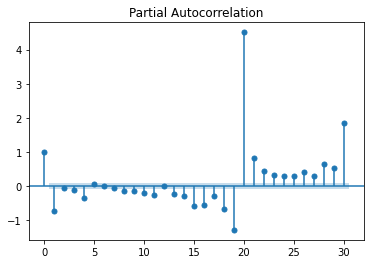

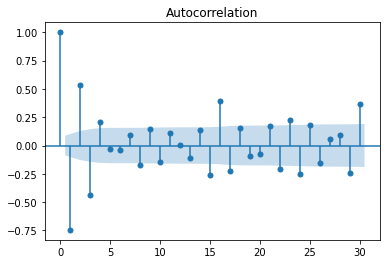

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller


daily_cases_df_copy = daily_cases_df.copy()
daily_cases_df_copy['diff_value'] = daily_cases_df_copy['value'].diff()
daily_cases_df_copy = daily_cases_df_copy.drop(daily_cases_df_copy.index[0])
plot_pacf(daily_cases_df_copy['diff_value'],lags=30);
plot_acf(daily_cases_df_copy['diff_value'],lags=30);
ad_fuller_result = adfuller(daily_cases_df_copy['diff_value'])
print(f'ADF Stat: {ad_fuller_result[0]}\np-value: {ad_fuller_result[1]}')

#### Not stationary will avoid arima based models for now

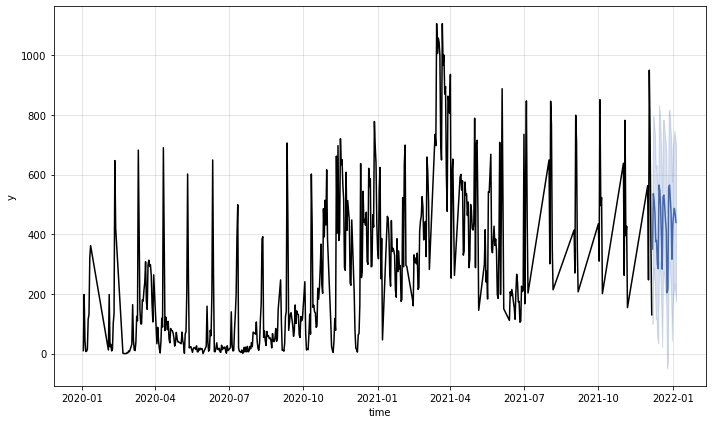

In [56]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (arima,sarima,holtwinters,linear_model,quadratic_model,theta,prophet,lstm)

model_params = EnsembleParams(
    [
        BaseModelParams('prophet',prophet.ProphetParams(
            growth="linear",
            changepoints=None,
            n_changepoints=10,
            changepoint_range=0.8,
            yearly_seasonality="auto",
            weekly_seasonality="auto",
            daily_seasonality="auto",
            holidays=None,
            seasonality_mode="additive",
            seasonality_prior_scale=20.0,
            holidays_prior_scale=10.0,
            changepoint_prior_scale=0.1,
            mcmc_samples=0,
            interval_width=0.80,
            uncertainty_samples=1000,
            cap=None,
            floor=None
        )),
    ]
)
KatsEnsembleParam = {
    'models':model_params,
    'aggregation':'median',
    'seasonality_length':12,
    'decomposition_method':'additive',
}
model = KatsEnsemble(data=daily_cases_ts,params=KatsEnsembleParam)
model.fit()
fcst = model.predict(steps=30)
model.aggregate()
model.plot()